# 統計的機械学習特論


## 概要
与えられた文章がSpamかそうではないかの２値分類問題を解く。

データは[UCIのSMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) を用いる。

分類の方法として、ロジスティック回帰を用いる。

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

## データセット
データは[UCIのSMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) を用いる。

https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip　をDLして直下に配置する。

5572件のSMSのデータセットで、そのうちスパムSMSが747件ある。

In [5]:
SEED = 0

spam_df = pd.read_csv("smsspamcollection/SMSSpamCollection", sep='\t', header=None)

# ラベルと文章を分ける
labels = spam_df[0].values
sentences = spam_df[1].values

label_dic = {'ham': 0, 'spam': 1}  # spamを真値とする
label_dic_inv = {v: k for k, v in label_dic.items()}
label_ids = [label_dic[i] for i in labels]

# 7:3に学習データとテストデータを分割する
train_sentence, test_sentence, y_train, y_test = train_test_split(sentences, label_ids, test_size=0.3, random_state=SEED, stratify=label_ids)

In [68]:
print(len(train_sentence))
print(len(test_sentence))

3900
1672


In [32]:
# spamの量
spam_df[0].value_counts()

ham     4825
spam     747
Name: 0, dtype: int64

---
## 前処理
sklearnのCountVectorizerを用いて、
文章をベクトル化する。

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_sentence)
X_test = vectorizer.transform(test_sentence)

In [64]:
len(vectorizer.get_feature_names())
print('Vocabulary size: {}'.format(len(vectorizer.vocabulary_)))

Vocabulary size: 7143


In [66]:
pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())

,00,000,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,...,zealand,zed,zeros,zindgi,zoe,zogtorius,zouk,zyada,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
## ロジスティック回帰による学習


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state=SEED, n_jobs=-1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(cm,columns=['Predicted ham', 'Predicted spam'], index=['Actual ham', 'Actual spam'])

,Predicted ham,Predicted spam
Actual ham,1444,4
Actual spam,33,191


## 評価

In [77]:
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[1444    4]
 [  33  191]]
accuracy =  0.9778708133971292
precision =  0.9794871794871794
recall =  0.8526785714285714
f1 score =  0.9116945107398569


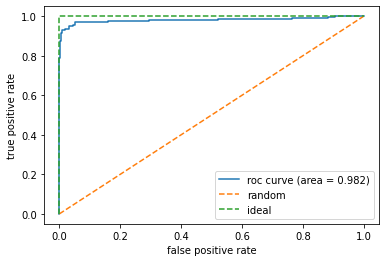

auc =  0.9819794544198895


In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_score = lr.predict_proba(X_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print('auc = ', roc_auc_score(y_true=y_test, y_score=y_score))

## 考察
可視化の実験を行う


In [79]:
from IPython.display import display, HTML

# 赤くハイライトする
def highlight_r(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

# 青くハイライトする
def highlight_b(word, attn):
  html_color = '#%02X%02X%02X' % (int(255*(1 - attn)), int(255*(1 - attn)), 255)
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def show_lr_explaination(check_idx):
    # 単語と説明変数の値の辞書
    coef_dic = {j: i for i, j in zip(lr.coef_[0], vectorizer.get_feature_names())}
        
    # 対象の文章の単語の説明変数の値を確認していく
    texts = test_sentence[check_idx].split()
    scores = []
    for w in texts:
        try:
            s = coef_dic[w]
        except KeyError:
            s = 0  # 対象外の単語は0を割り当てる
        scores.append(s)

    # 文章をハイライトしていく
    html_outputs = []
    for word, attn in zip(texts, scores):
        if attn < 0:
            html_outputs.append(highlight_b(word, attn*-1))
        else:
            html_outputs.append(highlight_r(word, attn))

    # 結果を表示
    display(HTML(' '.join(html_outputs)))

In [ ]:
# spamデータに対しての可視化
for i in range(len(y_test)):
    if y_test[i] == 1:
        show_lr_explaination(i)

In [ ]:
# 非spamデータに対しての可視化
for i in range(len(y_test)):
    if y_test[i] == 0:
        show_lr_explaination(i)